In [7]:
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.lines import Line2D
from importlib import reload

import KDTree2
from utilities import *
from obstacles import Range, Point, Line, Obstacle, Obstacles

import numpy as np
import math, random
import matplotlib.patches as patches
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.ops import cascaded_union
from descartes import PolygonPatch

In [2]:
def gen_valid_rand(valid_function):
    """ Generates a valid q_rand \in Q_free given a validity function """
    tmp = np.random.random(2) * span*1.1 + minp - span*0.05
    while not valid_function(*tmp):
        tmp = np.random.random(2) * span*1.1 + minp - span*0.05
    return tmp

In [3]:
init_t = math.atan(2.5)
r = math.hypot(10, 25)
thetas = [init_t, math.pi-init_t, math.pi+init_t, 2*math.pi-init_t]
def gen_rect_pts(x, y, alpha):
    return [(x+r*math.cos(theta+alpha), y+r*math.sin(theta+alpha))
               for theta in thetas]

In [4]:
obstacle_path, goal_path = "world_obstacles.txt", "start_goal.txt"

step_size   = 10
path        = get_obstacle_course(obstacle_path)
start, goal = get_start_and_goal(goal_path)
obstacles   = Obstacles(path.to_polygons())
end         = np.array(goal)

minp, maxp  = path.vertices.min(0), path.vertices.max(0)
span        = maxp - minp


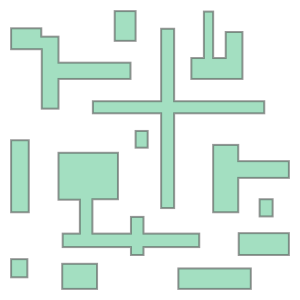

In [8]:
shapes = [Polygon(tmp) for tmp in path.to_polygons()]
steps = 10

def check_collision(start, end):
    x1, y1, a1 = start
    x2, y2, a2 = end
    
    delx, dely, dela = (x2-x1)/steps, (y2-y1)/steps, (a2-a1)/steps
    poly3 = cascaded_union([Polygon(gen_rect_pts(x1+delx*i, y1+dely*i, a1+dela*i)) for i in range(steps)])
    for shape in shapes:
        if shape.intersects(poly3): return True, poly3
    return False, poly3

KeyboardInterrupt: 

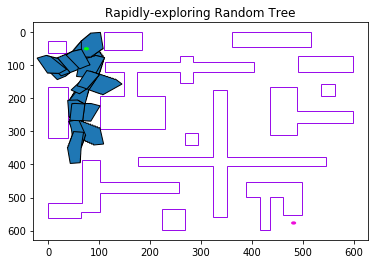

In [15]:
# obstacle_path, goal_path = "../hw3/world_obstacles.txt", "../hw3/goal.txt"
obstacle_path, goal_path = "world_obstacles.txt", "start_goal.txt"

step_size   = 50
path        = get_obstacle_course(obstacle_path)
start, goal = (75, 50, 0), (482,577,math.pi/2)
obstacles   = Obstacles(path.to_polygons())
end         = np.array(goal)

fig, ax = plt.subplots()
draw_obstacle_course(path, ax)
draw_start_and_goal(ax=ax, goal=goal, start=start)

minp, maxp  = path.vertices.min(0), path.vertices.max(0)
span        = maxp - minp

KD = KDTree2.KDTree(start[:2], 0)
ax.add_patch(PolygonPatch(Polygon(gen_rect_pts(*start)), color='red'))

near_count = 0
count = 0
while KD.length < 100:
    count += 1
    # Select a random point q_rand \in Q_free
    q_rand = gen_valid_rand(obstacles.point_is_valid) if np.random.randint(0, 100)>5 else end

    # Find the nearest node and distance to it
    q_near, dist = KD.nearestNode(q_rand)
    
    # Generate the next node in the direction of q_rand
    if dist < step_size: q_next = tuple(q_rand)
    else:
        q_next = gen_next(tuple(q_near.node), q_rand, step_size)
        if not obstacles.point_is_valid(*q_next): continue
    
    # Check validity and update tree
    for i in range(10):
        alpha_new = (np.random.random() * math.pi/4+q_near.alpha)-math.pi/8
        collides, poly3 = check_collision((*q_near.node, q_near.alpha), (*q_next, alpha_new))
        if not collides: break
    else: continue
    
    KD.addNode(q_next, alpha_new)
    ax.add_patch(PolygonPatch(poly3))

    if math.hypot(q_next[0]-goal[0], q_next[1]-goal[1]) < step_size and \
        not check_collision((*q_next, alpha_new), goal):
        break

print("n =", KD.length)